### Chargement du dataset

In [1]:
csv_pvf10 = "../data/processed/structure_pvf_10.csv"

In [2]:
import pandas as pd
import numpy as np

# Charger le dataframe à partir du dataset
def load_df_from_dataset(csv_path,ensemble,format):
    # Charger le fichier CSV
    df_pvf10 = pd.read_csv(csv_path)
    # Filtrer par ensemble (train/test) et par format
    df_pvf10 = df_pvf10.loc[(df_pvf10['Train_Test'] == ensemble) & (df_pvf10['Format'] == format)]   
    return df_pvf10

# Chargement dataframes d'entraînement et de test
df_train = load_df_from_dataset(csv_pvf10, 'train','110x60')
df_test = load_df_from_dataset(csv_pvf10, 'test','110x60')

# Séparation features / cible
X_train = df_train.drop('Classe',axis=1)
y_train = df_train['Classe']
X_test = df_test.drop('Classe',axis=1)
y_test = df_test['Classe']

### Pipeline 1 : vecteurs HOG

#### Transformeur pour extraction des vecteurs HOG

In [3]:
import cv2
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

# Transformeur qui renvoie le dataframe des vecteurs HOG
class HOGExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110), pixels_per_cell=(8,8),cells_per_block=(2,2)):
        self.image_size = image_size
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.feature_names_ = None

    # Méthode d'extraction du vecteur HOG d'une image
    def extract_hog(self, gray_img):
        hog_vector = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            feature_vector=True
        )
        return hog_vector
    
    # Le fit ne sert qu'à récupérer le nom des features créées
    def fit(self, X, y=None):
        # On utilise une seule image
        img = cv2.imread(X['Chemin'].iloc[0])
        # Conversion en niveaux de gris et resizing
        img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
        # Extraction du vecteur HOG
        hog_vector = self.extract_hog(img_gray_resized)
        # On en déduit le nom des features
        self.feature_names_ =  [f'HOG_{i+1}' for i in range(len(hog_vector))]
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs HOG
        hog_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur HOG
            hog_vector = self.extract_hog(img_gray_resized)
            hog_vectors.append(hog_vector)
        # On renvoie le dataframe des vecteurs HOG
        return pd.DataFrame(hog_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
hog_extr = HOGExtractor()

#### Standardisation

In [4]:
from sklearn.preprocessing import StandardScaler

# Création du StandardScaler
hog_st = StandardScaler()


#### Création Pipeline HOG

In [5]:
from sklearn.pipeline import Pipeline

HOGPipeline = Pipeline(steps=[
    ("Extraction HOG",hog_extr),
    ("Standardisation",hog_st)
]) 

### Pipeline 2 : vecteurs GLCM 

#### Transformeur pour extraction des vecteurs GLCM

In [7]:
from skimage.feature import graycomatrix, graycoprops

# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),
                 glcm_distances=[1],
                 glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                 glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']):
        self.image_size = image_size
        self.glcm_distances = glcm_distances
        self.glcm_angles = glcm_angles
        self.glcm_props = glcm_props
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = []
        # Pour chaque propriété, chaque distance et chaque angle
        for prop in self.glcm_props:
            for distance in self.glcm_distances:
                for angle in self.glcm_angles:
                    # On stocke dans les noms des features un label du type : contrast_d1_a45
                    self.feature_names_.append(f"{prop}_d{distance}_a{np.degrees(angle):.0f}")

    # Méthode d'extraction des caractéristiques GLCM d'une image
    def extract_glcm(self, gray_img):
        glcm_vector = []
        # Calcul de la matrice GLCM (256 x 256 x distances x angles)
        glcm = graycomatrix(
            gray_img,
            distances=self.glcm_distances,
            angles=self.glcm_angles,
            levels=256
        )
        # Pour chaque propriété GLCM
        for prop in self.glcm_props:
            # On la calcule pour les différentes distances et les différents angles 
            prop_matrix = graycoprops(glcm, prop)  # Matrice distances x angles
            # On transforme la matrice en vecteur qu'on stocke dans glcm_vector
            glcm_vector.extend(prop_matrix.flatten())
        return glcm_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur GLCM
            glcm_vector = self.extract_glcm(img_gray_resized)
            glcm_vectors.append(glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame(glcm_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
glcm_extr = GLCMExtractor()

#### Standardisation

In [8]:
# Création du StandardScaler
glcm_st = StandardScaler()

#### Création Pipeline GLCM

In [9]:
GLCMPipeline = Pipeline(steps=[
    ("Extraction GLCM",glcm_extr),
    ("Standardisation",glcm_st)
]) 

### Pipeline 3 : vecteurs Entropie

#### Transformeur pour extraction des vecteurs caractéristiques de l'entropie

In [11]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.stats import skew, kurtosis

# Transformeur qui renvoie le dataframe des caractéristiques de l'entropie
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),radius=4, bins=10, include_histogram=True):
        self.image_size = image_size
        self.radius = radius
        self.bins = bins
        self.include_histogram = include_histogram
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['entropy_mean', 'entropy_std', 'entropy_min','entropy_max', 'entropy_median', 'entropy_skew', 'entropy_kurtosis']
        # Si histogramme demandé
        if include_histogram:
            self.feature_names_.extend([f'entropy_hist_bin{i+1}' for i in range(self.bins)])
        
    # Méthode d'extraction des caractéristiques de l'entropie d'une image
    def extract_entropy(self, gray_img):
        # Calcul de la carte d'entropie
        entropie = entropy(gray_img, disk(self.radius))
        # Calcul des statistiques associées
        entropy_vector = [
                np.mean(entropie),
                np.std(entropie),
                np.min(entropie),
                np.max(entropie),
                np.median(entropie),
                skew(entropie.ravel()),
                kurtosis(entropie.ravel())
            ]
        # Si histogramme demandé
        if (self.include_histogram):
            hist, bin_edges = np.histogram(entropie, bins=self.bins, range=(0, np.max(entropie)), density=True)
            # On l'ajoute au vecteur des caractéristiques de l'entropie
            entropy_vector.extend(list(hist))

        return entropy_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur de l'entropie
            entropy_vector = self.extract_entropy(img_gray_resized)
            entropy_vectors.append(entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame(entropy_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
entropy_extr = EntropyExtractor()

#### Standardisation

In [12]:
# Création du StandardScaler
entropy_st = StandardScaler()

#### Création pipeline Entropie

In [13]:
EntropyPipeline = Pipeline(steps=[
    ("Entropie",entropy_extr),
    ("Standardisation",entropy_st)
]) 

### Pipeline 4 : pixels bruts

#### Transformeur pour extraction des pixels bruts

In [15]:
# Transformeur qui renvoie le dataframe des pixels bruts
class PixelsBrutsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(30,55)):
        self.image_size = image_size
        # Nom des features : Pixel1, Pixel2...
        self.feature_names_ = [f"Pixel{i+1}" for i in range(image_size[0]*image_size[1])]  

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs des pixels bruts
        brut_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur des pixels bruts
            brut_vector = img_gray_resized.flatten()
            brut_vectors.append(brut_vector)
        # On renvoie le dataframe des vecteurs des pixels bruts
        return pd.DataFrame(brut_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
pixbrut_extr = PixelsBrutsExtractor()

#### Standardisation

In [16]:
# Création du StandardScaler
pixbrut_st = StandardScaler()

#### Création Pipeline Pixels Bruts

In [17]:
PixelsBrutsPipeline = Pipeline(steps=[
    ("Pixels bruts",pixbrut_extr),
    ("Standardisation",pixbrut_st)
]) 

### Pipelines finales avec modèle SVM

In [19]:
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC

svm = SVC(kernel="rbf", gamma="scale",C=10)

finalPipelines = {
    "Pixels Bruts + SVM" : Pipeline(steps=[
        ('Preprocessing',PixelsBrutsPipeline),
        ('Modeling',svm)]),

    "HOG + SVM" : Pipeline(steps=[
        ('Preprocessing',HOGPipeline),
        ('Modeling',svm)]),

    "GLCM + SVM" : Pipeline(steps=[
        ('Preprocessing',GLCMPipeline),
        ('Modeling',svm)]),

    "Entropie + SVM" : Pipeline(steps=[
        ('Preprocessing',EntropyPipeline),
        ('Modeling',svm)]),

    "HOG/GLCM + SVM" : Pipeline(steps=[
        ('Preprocessing',FeatureUnion([
            ('Pipeline HOG',HOGPipeline),
            ('Pipeline GLCM',GLCMPipeline)])),
        ('Modeling',svm)]),

    "HOG/Entropie + SVM" : Pipeline(steps=[
        ('Preprocessing',FeatureUnion([
            ('Pipeline HOG',HOGPipeline),
            ('Pipeline Entropie',EntropyPipeline)])),
        ('Modeling',svm)]),
    
    "GLCM/Entropie + SVM" : Pipeline(steps=[
        ('Preprocessing',FeatureUnion([
            ('Pipeline GLCM',GLCMPipeline),
            ('Pipeline Entropie',EntropyPipeline)])),
        ('Modeling',svm)]),

    "HOG/GLCM/Entropie + SVM" : Pipeline(steps=[
        ('Preprocessing',FeatureUnion([
            ('Pipeline HOG',HOGPipeline),
            ('Pipeline GLCM',GLCMPipeline),
            ('Pipeline Entropie',EntropyPipeline)])),
        ('Modeling',svm)]),
}


### Entraînement et évaluation


Entraînement :  Pixels Bruts + SVM


Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('Pixels bruts', PixelsBrutsExtractor()),
                                 ('Standardisation', StandardScaler())])),
                ('Modeling', SVC(C=10))])

,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,...,Pixel1641,Pixel1642,Pixel1643,Pixel1644,Pixel1645,Pixel1646,Pixel1647,Pixel1648,Pixel1649,Pixel1650
553,1.273238,1.283167,0.750947,0.883879,0.186705,0.964649,1.057772,0.672442,0.943156,0.146696,...,0.959871,0.970500,0.974706,1.108001,1.227443,1.172912,1.198533,1.390834,1.393375,1.380736
554,1.437142,1.305504,1.134625,1.040245,0.970585,0.964649,1.057772,1.078390,1.192144,1.176120,...,0.867374,1.016336,1.088169,1.198313,1.227443,1.374500,1.615130,1.694493,1.676005,1.712568
555,2.116173,0.389692,1.157194,1.688050,0.500257,0.446887,-0.138905,-0.184560,0.603626,0.444085,...,0.428013,0.443387,0.430086,0.408082,0.369549,0.321762,0.299561,0.306338,0.371559,0.495850
556,1.718121,1.305504,1.247471,1.196612,1.194551,1.144740,1.125509,1.168600,1.101603,0.970235,...,0.312392,0.237125,0.203161,0.227458,0.256668,0.299363,0.255709,0.176199,0.132411,0.208263
557,1.671291,0.166323,0.976640,1.598697,0.791413,1.144740,-0.048590,0.514573,1.124238,0.695722,...,0.404889,0.374633,0.362009,0.362926,0.324397,0.299363,0.277635,0.262958,0.328078,0.473728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-0.974588,-0.972858,-0.941750,-0.925506,-0.955520,-0.971332,-0.861428,-0.906245,-0.935575,-0.836976,...,-1.236933,-1.229625,-1.203775,-1.149801,-1.143054,-1.156552,-1.059860,-1.081817,-1.019849,-1.119065
5568,-0.318972,-0.280415,-0.264671,-0.255364,-0.216433,-0.521104,-0.951743,-0.906245,-0.890304,-0.836976,...,0.011776,-0.037891,-0.023764,-0.043478,-0.014246,-0.036617,-0.029331,-0.019011,0.045448,0.186141
5569,-0.506291,-0.503784,-0.512933,-0.501082,-0.507589,-0.431058,-0.432430,-0.455192,-0.505504,-0.448082,...,-0.311963,-0.312906,-0.273382,-0.291836,-0.262583,-0.238205,-0.270519,-0.235910,-0.128478,-0.057203
5570,-1.044833,-0.995195,-1.054596,-1.081873,-0.977917,-1.038866,-1.042059,-1.109219,-1.456187,-1.363126,...,-1.121312,-1.115035,-1.044927,-1.059489,-1.052749,-1.044558,-1.037934,-0.995057,-0.976367,-0.897844


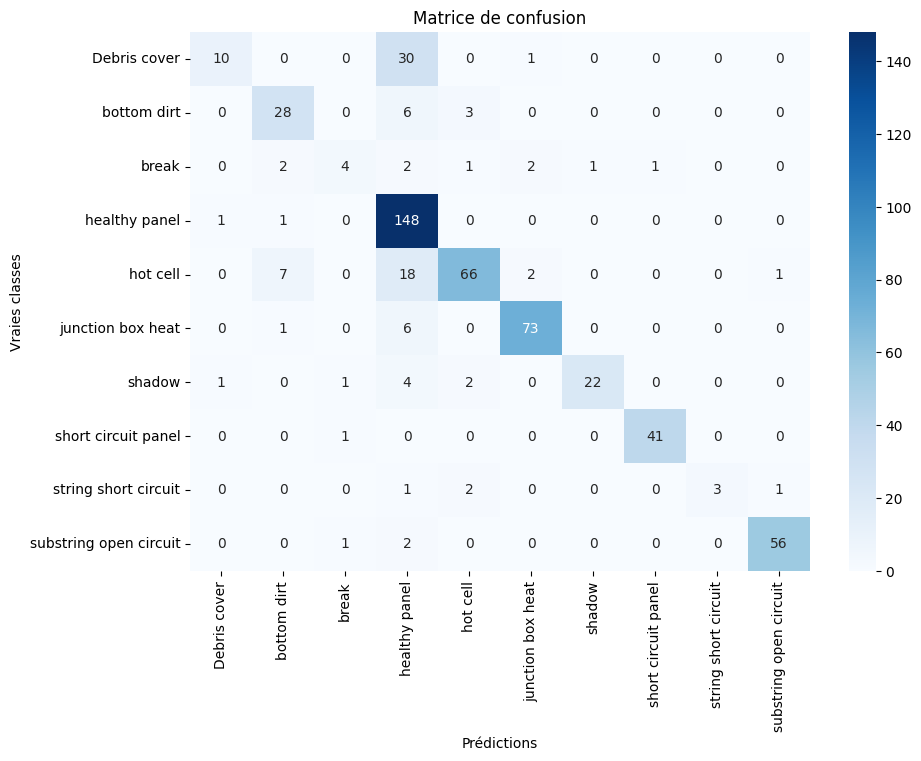

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.83      0.24      0.38        41
           bottom dirt       0.72      0.76      0.74        37
                 break       0.57      0.31      0.40        13
         healthy panel       0.68      0.99      0.81       150
              hot cell       0.89      0.70      0.79        94
     junction box heat       0.94      0.91      0.92        80
                shadow       0.96      0.73      0.83        30
   short circuit panel       0.98      0.98      0.98        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.97      0.95      0.96        59

              accuracy                           0.82       553
             macro avg       0.85      0.70      0.74       553
          weighted avg       0.84      0.82      0.80       553


Entraînement :  HOG + SVM


Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('Extraction HOG', HOGExtractor()),
                                 ('Standardisation', StandardScaler())])),
                ('Modeling', SVC(C=10))])

,HOG_1,HOG_2,HOG_3,HOG_4,HOG_5,HOG_6,HOG_7,HOG_8,HOG_9,HOG_10,...,HOG_2583,HOG_2584,HOG_2585,HOG_2586,HOG_2587,HOG_2588,HOG_2589,HOG_2590,HOG_2591,HOG_2592
553,0.086439,-1.040365,-0.091048,-1.072702,-0.020514,-0.170390,2.587848,1.772925,1.189901,0.876797,...,1.728162,0.035832,-0.363332,-0.277724,1.204166,0.699405,0.261498,0.212594,0.069487,-0.890444
554,0.108499,2.008504,0.562817,-1.585915,0.003353,-0.239505,2.766472,2.468437,1.205065,-0.707659,...,0.968124,0.565855,-0.047056,0.121597,-0.068389,-0.392458,0.401170,-0.095171,-0.164767,0.556121
555,0.303547,-1.306800,0.666634,1.451114,0.214368,0.159273,1.714925,0.768587,-1.111446,1.064260,...,-0.723561,0.397393,1.113071,0.172811,-0.602756,-1.321660,-0.929605,-0.658057,-0.130527,-0.286923
556,-0.722137,-0.796724,-0.496764,1.508291,0.286981,2.112880,-0.933379,1.752289,-0.214083,-1.579702,...,-0.723561,0.644533,0.411894,-1.210442,-0.449266,-1.049951,1.620709,1.601057,1.876357,0.922421
557,-0.138577,-1.306800,1.546047,1.074484,-0.263950,-0.462960,0.497094,2.451237,0.795502,0.682506,...,-0.352338,0.501338,-0.136377,0.614978,-0.708973,0.616767,-0.286518,-0.251194,-0.833739,-0.514422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.739882,-0.589807,-1.009914,-0.076043,0.686424,-1.110611,-0.355057,-0.622813,1.180160,-0.646468,...,-0.723561,0.462148,-0.685904,0.562599,-0.466624,-0.348667,-0.021257,1.394805,0.592125,-0.523219
5568,0.102156,-0.040069,-1.008694,0.145306,0.545428,0.237740,1.016495,0.327185,-0.685772,1.328485,...,-0.723561,-1.076355,-0.787470,-0.035402,0.650277,0.390692,0.292455,1.613002,0.785161,-0.663759
5569,-0.229819,-0.059954,-0.065107,0.996758,-0.719961,0.944271,-0.279654,-0.867831,-1.111446,-0.055094,...,-0.723561,-0.753348,-1.210308,-1.282802,-1.230258,-1.270593,-0.272706,1.390018,0.593335,-0.661281
5570,1.163553,-1.122375,-0.908484,-1.266511,-0.649402,-0.689188,0.143030,-0.867831,1.079193,1.806835,...,-0.723561,0.065224,-0.973543,0.848740,-0.770557,0.227188,-0.541412,-0.035244,0.251073,-0.890444


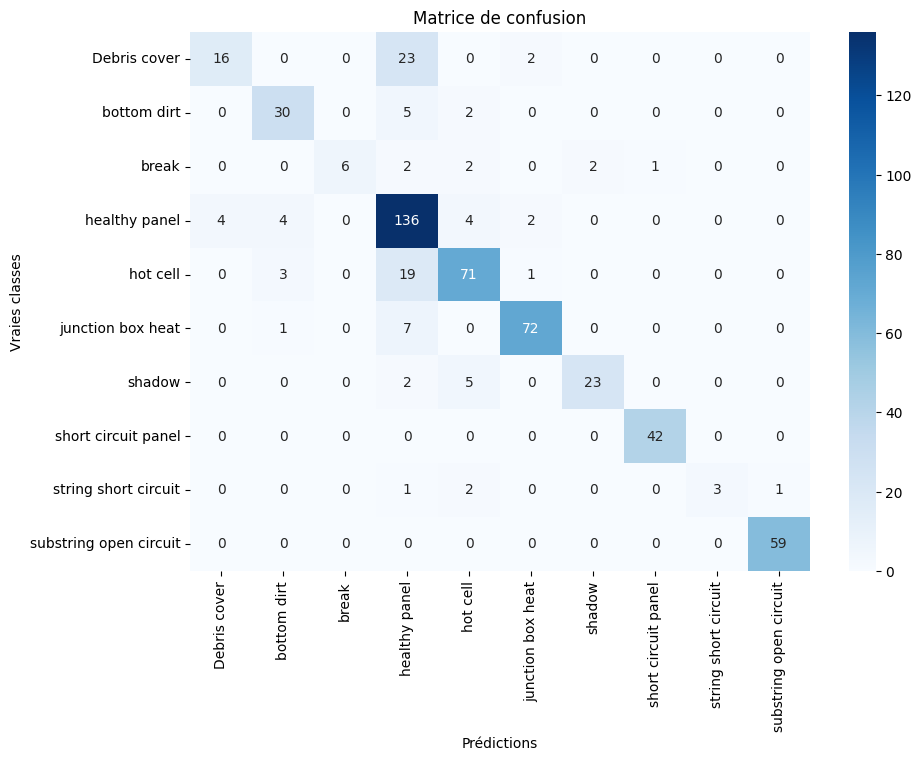

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.80      0.39      0.52        41
           bottom dirt       0.79      0.81      0.80        37
                 break       1.00      0.46      0.63        13
         healthy panel       0.70      0.91      0.79       150
              hot cell       0.83      0.76      0.79        94
     junction box heat       0.94      0.90      0.92        80
                shadow       0.92      0.77      0.84        30
   short circuit panel       0.98      1.00      0.99        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      1.00      0.99        59

              accuracy                           0.83       553
             macro avg       0.89      0.74      0.79       553
          weighted avg       0.84      0.83      0.82       553


Entraînement :  GLCM + SVM


Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('Extraction GLCM', GLCMExtractor()),
                                 ('Standardisation', StandardScaler())])),
                ('Modeling', SVC(C=10))])

,contrast_d1_a0,contrast_d1_a45,contrast_d1_a90,contrast_d1_a135,dissimilarity_d1_a0,dissimilarity_d1_a45,dissimilarity_d1_a90,dissimilarity_d1_a135,homogeneity_d1_a0,homogeneity_d1_a45,homogeneity_d1_a90,homogeneity_d1_a135,energy_d1_a0,energy_d1_a45,energy_d1_a90,energy_d1_a135,correlation_d1_a0,correlation_d1_a45,correlation_d1_a90,correlation_d1_a135
553,-0.202637,-0.276631,-0.126860,-0.258727,0.011815,-0.194511,-0.070816,-0.181414,-0.555304,-0.415650,-0.088003,-0.350953,-0.069656,-0.097067,0.062365,-0.075273,-1.120428,-1.267769,-1.627671,-1.579209
554,-0.826254,-0.724360,-0.456227,-0.742628,-0.483174,-0.458639,-0.356662,-0.515905,-0.661548,-0.513246,0.038292,-0.361616,-0.202365,-0.235180,-0.002971,-0.189325,-0.143459,-0.581465,-1.125762,-0.378343
555,-0.628240,-0.262360,0.154932,-0.245153,-0.657592,-0.305244,0.034106,-0.313091,0.317455,0.137411,0.096814,0.075257,0.790379,0.669581,0.730184,0.627575,-0.432265,-2.094368,-3.922477,-1.995713
556,-0.873160,-0.683151,-0.260667,-0.632054,-0.673276,-0.511825,-0.130854,-0.430826,-0.122626,0.027070,0.058677,-0.044518,0.428554,0.440723,0.558037,0.421453,-0.327578,-1.486102,-3.507698,-1.680989
557,0.366109,0.259110,0.500173,0.320163,0.358067,0.137118,0.376751,0.166255,-0.192226,-0.100234,0.031944,-0.085424,0.467523,0.445727,0.626800,0.439626,-1.462935,-2.000990,-2.731774,-2.021940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-0.908163,-0.850679,-0.549503,-0.857648,-1.410072,-1.157166,-0.844138,-1.179637,1.817506,1.860500,1.446118,1.968996,1.712237,1.685085,1.465567,1.642020,-0.710008,-1.092218,-2.225412,-1.048111
5568,-0.740337,-0.707541,-0.483492,-0.705737,-1.070025,-0.791596,-0.452329,-0.791577,0.968614,0.484343,-0.061198,0.452277,0.255542,0.139006,-0.040155,0.077409,0.197117,0.213378,-0.048104,0.174041
5569,-0.983681,-0.852220,-0.569450,-0.860764,-1.135001,-0.818047,-0.506352,-0.853930,0.696979,0.351312,0.071209,0.499674,0.097763,-0.013256,-0.188890,-0.040955,0.643596,0.527201,0.064617,0.464378
5570,-0.971153,-0.920115,-0.683515,-0.928491,-1.365778,-1.164466,-0.916785,-1.183552,1.671042,1.808309,1.370858,1.826946,2.155377,2.227835,1.940743,2.139901,-0.491782,-0.648136,-0.715804,-0.610882


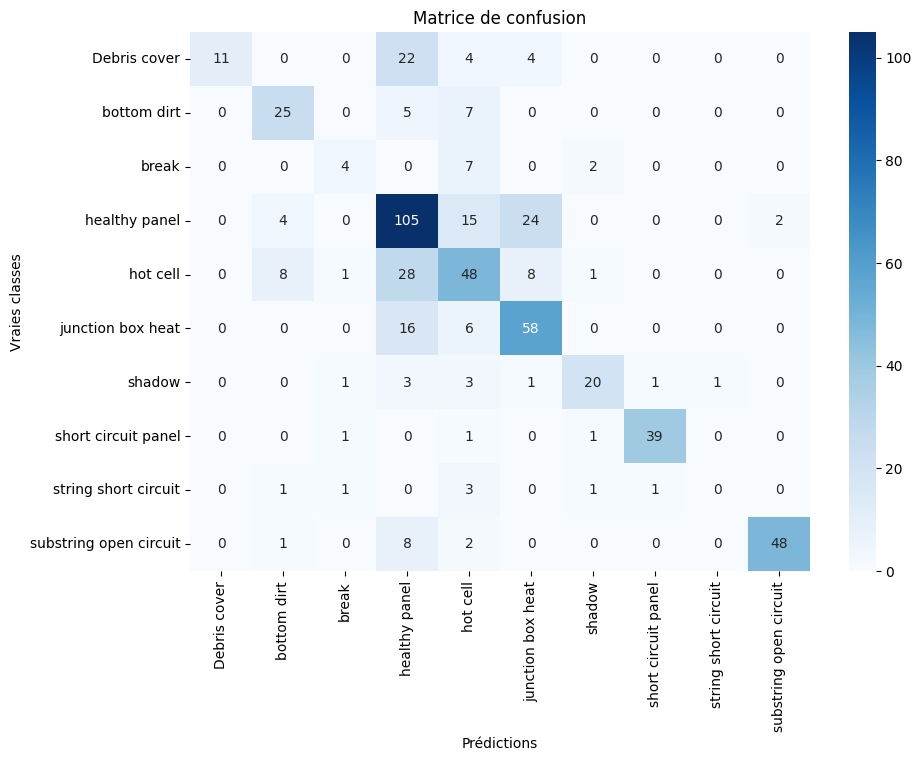

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       1.00      0.27      0.42        41
           bottom dirt       0.64      0.68      0.66        37
                 break       0.50      0.31      0.38        13
         healthy panel       0.56      0.70      0.62       150
              hot cell       0.50      0.51      0.51        94
     junction box heat       0.61      0.72      0.66        80
                shadow       0.80      0.67      0.73        30
   short circuit panel       0.95      0.93      0.94        42
  string short circuit       0.00      0.00      0.00         7
substring open circuit       0.96      0.81      0.88        59

              accuracy                           0.65       553
             macro avg       0.65      0.56      0.58       553
          weighted avg       0.67      0.65      0.64       553


Entraînement :  Entropie + SVM


Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('Entropie', EntropyExtractor()),
                                 ('Standardisation', StandardScaler())])),
                ('Modeling', SVC(C=10))])

,entropy_mean,entropy_std,entropy_min,entropy_max,entropy_median,entropy_skew,entropy_kurtosis,entropy_hist_bin1,entropy_hist_bin2,entropy_hist_bin3,entropy_hist_bin4,entropy_hist_bin5,entropy_hist_bin6,entropy_hist_bin7,entropy_hist_bin8,entropy_hist_bin9,entropy_hist_bin10
553,0.371362,-1.571291,1.368703,-0.175648,0.159402,0.973214,0.164597,-0.183827,-0.512681,-0.868177,-1.259075,-0.628838,1.690952,1.916545,0.067706,-0.083276,-0.132783
554,0.362522,-1.334341,0.786884,-0.091889,0.305803,-0.277193,0.243801,-0.183827,-0.512681,-0.805495,-0.970846,-0.628580,0.906470,1.625881,0.598936,0.065848,-0.651549
555,-0.073051,-0.290080,0.359927,0.644883,-0.134425,1.159993,1.246367,-0.183827,-0.482659,-0.429826,-0.128892,0.649084,1.570608,0.701699,-1.302064,-1.070062,-0.002375
556,0.022243,-0.863823,0.650072,0.398618,0.006989,0.199669,-0.085626,-0.183827,-0.502524,-0.608436,-0.387017,0.546924,1.124659,0.798997,-0.224632,-0.724215,-0.821468
557,0.087078,0.371116,0.532076,0.679801,-0.155288,1.164291,-0.313660,-0.183827,-0.482722,-0.566692,0.019788,0.875932,0.909684,-0.329658,-1.009195,-0.302188,0.027692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-1.808873,-1.475991,-1.679146,-3.860215,-1.651314,0.221624,-0.919894,0.104159,0.118425,-0.011108,1.350189,2.209691,0.409856,0.514198,1.203900,-0.295145,-0.581662
5568,-0.463169,-0.939360,0.632876,-2.243417,-0.312075,-0.155681,-1.144134,-0.183827,-0.512681,-0.755244,-0.439769,0.701163,0.141966,0.164365,1.225788,1.194742,0.494842
5569,-0.439720,-1.237561,1.167381,-2.142763,-0.479658,0.459769,-1.010263,-0.183827,-0.512681,-0.847730,-0.772325,0.553379,1.389111,0.726761,0.462384,0.889394,0.662994
5570,-1.856049,-0.642584,-1.307140,-3.343982,-1.673394,0.349335,-1.151872,0.037168,0.684906,1.580292,1.493804,1.102614,0.054261,0.255414,0.407380,-0.452721,-0.476937


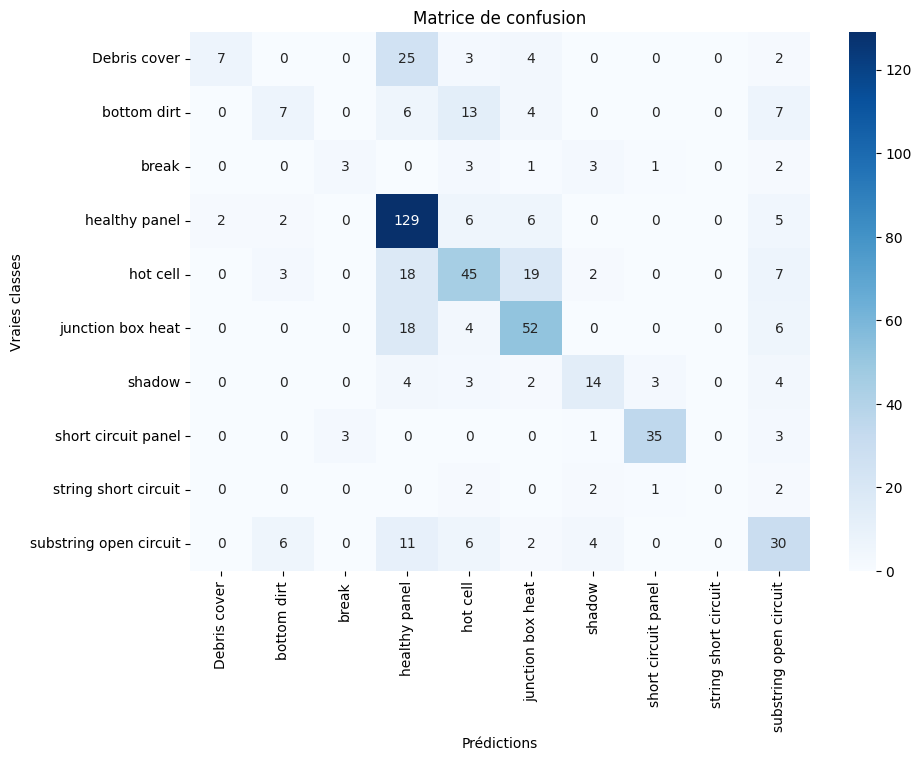

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.78      0.17      0.28        41
           bottom dirt       0.39      0.19      0.25        37
                 break       0.50      0.23      0.32        13
         healthy panel       0.61      0.86      0.71       150
              hot cell       0.53      0.48      0.50        94
     junction box heat       0.58      0.65      0.61        80
                shadow       0.54      0.47      0.50        30
   short circuit panel       0.88      0.83      0.85        42
  string short circuit       0.00      0.00      0.00         7
substring open circuit       0.44      0.51      0.47        59

              accuracy                           0.58       553
             macro avg       0.52      0.44      0.45       553
          weighted avg       0.58      0.58      0.56       553


Entraînement :  HOG/GLCM + SVM


d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Pipeline(steps=[('Preprocessing',
                 FeatureUnion(transformer_list=[('Pipeline HOG',
                                                 Pipeline(steps=[('Extraction '
                                                                  'HOG',
                                                                  HOGExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())])),
                                                ('Pipeline GLCM',
                                                 Pipeline(steps=[('Extraction '
                                                                  'GLCM',
                                                                  GLCMExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())]))])),
                ('Modeling', SVC(C=10))])

,Pipeline HOG__HOG_1,Pipeline HOG__HOG_2,Pipeline HOG__HOG_3,Pipeline HOG__HOG_4,Pipeline HOG__HOG_5,Pipeline HOG__HOG_6,Pipeline HOG__HOG_7,Pipeline HOG__HOG_8,Pipeline HOG__HOG_9,Pipeline HOG__HOG_10,...,Pipeline GLCM__homogeneity_d1_a90,Pipeline GLCM__homogeneity_d1_a135,Pipeline GLCM__energy_d1_a0,Pipeline GLCM__energy_d1_a45,Pipeline GLCM__energy_d1_a90,Pipeline GLCM__energy_d1_a135,Pipeline GLCM__correlation_d1_a0,Pipeline GLCM__correlation_d1_a45,Pipeline GLCM__correlation_d1_a90,Pipeline GLCM__correlation_d1_a135
553,0.086439,-1.040365,-0.091048,-1.072702,-0.020514,-0.170390,2.587848,1.772925,1.189901,0.876797,...,-0.088003,-0.350953,-0.069656,-0.097067,0.062365,-0.075273,-1.120428,-1.267769,-1.627671,-1.579209
554,0.108499,2.008504,0.562817,-1.585915,0.003353,-0.239505,2.766472,2.468437,1.205065,-0.707659,...,0.038292,-0.361616,-0.202365,-0.235180,-0.002971,-0.189325,-0.143459,-0.581465,-1.125762,-0.378343
555,0.303547,-1.306800,0.666634,1.451114,0.214368,0.159273,1.714925,0.768587,-1.111446,1.064260,...,0.096814,0.075257,0.790379,0.669581,0.730184,0.627575,-0.432265,-2.094368,-3.922477,-1.995713
556,-0.722137,-0.796724,-0.496764,1.508291,0.286981,2.112880,-0.933379,1.752289,-0.214083,-1.579702,...,0.058677,-0.044518,0.428554,0.440723,0.558037,0.421453,-0.327578,-1.486102,-3.507698,-1.680989
557,-0.138577,-1.306800,1.546047,1.074484,-0.263950,-0.462960,0.497094,2.451237,0.795502,0.682506,...,0.031944,-0.085424,0.467523,0.445727,0.626800,0.439626,-1.462935,-2.000990,-2.731774,-2.021940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.739882,-0.589807,-1.009914,-0.076043,0.686424,-1.110611,-0.355057,-0.622813,1.180160,-0.646468,...,1.446118,1.968996,1.712237,1.685085,1.465567,1.642020,-0.710008,-1.092218,-2.225412,-1.048111
5568,0.102156,-0.040069,-1.008694,0.145306,0.545428,0.237740,1.016495,0.327185,-0.685772,1.328485,...,-0.061198,0.452277,0.255542,0.139006,-0.040155,0.077409,0.197117,0.213378,-0.048104,0.174041
5569,-0.229819,-0.059954,-0.065107,0.996758,-0.719961,0.944271,-0.279654,-0.867831,-1.111446,-0.055094,...,0.071209,0.499674,0.097763,-0.013256,-0.188890,-0.040955,0.643596,0.527201,0.064617,0.464378
5570,1.163553,-1.122375,-0.908484,-1.266511,-0.649402,-0.689188,0.143030,-0.867831,1.079193,1.806835,...,1.370858,1.826946,2.155377,2.227835,1.940743,2.139901,-0.491782,-0.648136,-0.715804,-0.610882


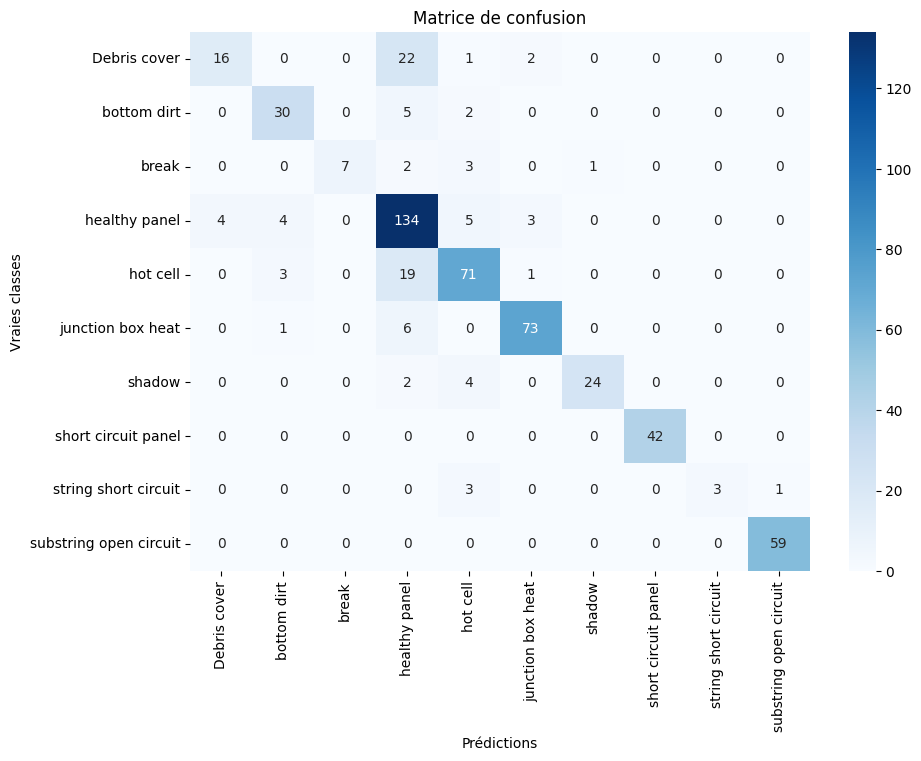

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.80      0.39      0.52        41
           bottom dirt       0.79      0.81      0.80        37
                 break       1.00      0.54      0.70        13
         healthy panel       0.71      0.89      0.79       150
              hot cell       0.80      0.76      0.78        94
     junction box heat       0.92      0.91      0.92        80
                shadow       0.96      0.80      0.87        30
   short circuit panel       1.00      1.00      1.00        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      1.00      0.99        59

              accuracy                           0.83       553
             macro avg       0.90      0.75      0.80       553
          weighted avg       0.84      0.83      0.82       553


Entraînement :  HOG/Entropie + SVM


Pipeline(steps=[('Preprocessing',
                 FeatureUnion(transformer_list=[('Pipeline HOG',
                                                 Pipeline(steps=[('Extraction '
                                                                  'HOG',
                                                                  HOGExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())])),
                                                ('Pipeline Entropie',
                                                 Pipeline(steps=[('Entropie',
                                                                  EntropyExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())]))])),
                ('Modeling', SVC(C=10))])

,Pipeline HOG__HOG_1,Pipeline HOG__HOG_2,Pipeline HOG__HOG_3,Pipeline HOG__HOG_4,Pipeline HOG__HOG_5,Pipeline HOG__HOG_6,Pipeline HOG__HOG_7,Pipeline HOG__HOG_8,Pipeline HOG__HOG_9,Pipeline HOG__HOG_10,...,Pipeline Entropie__entropy_hist_bin1,Pipeline Entropie__entropy_hist_bin2,Pipeline Entropie__entropy_hist_bin3,Pipeline Entropie__entropy_hist_bin4,Pipeline Entropie__entropy_hist_bin5,Pipeline Entropie__entropy_hist_bin6,Pipeline Entropie__entropy_hist_bin7,Pipeline Entropie__entropy_hist_bin8,Pipeline Entropie__entropy_hist_bin9,Pipeline Entropie__entropy_hist_bin10
553,0.086439,-1.040365,-0.091048,-1.072702,-0.020514,-0.170390,2.587848,1.772925,1.189901,0.876797,...,-0.183827,-0.512681,-0.868177,-1.259075,-0.628838,1.690952,1.916545,0.067706,-0.083276,-0.132783
554,0.108499,2.008504,0.562817,-1.585915,0.003353,-0.239505,2.766472,2.468437,1.205065,-0.707659,...,-0.183827,-0.512681,-0.805495,-0.970846,-0.628580,0.906470,1.625881,0.598936,0.065848,-0.651549
555,0.303547,-1.306800,0.666634,1.451114,0.214368,0.159273,1.714925,0.768587,-1.111446,1.064260,...,-0.183827,-0.482659,-0.429826,-0.128892,0.649084,1.570608,0.701699,-1.302064,-1.070062,-0.002375
556,-0.722137,-0.796724,-0.496764,1.508291,0.286981,2.112880,-0.933379,1.752289,-0.214083,-1.579702,...,-0.183827,-0.502524,-0.608436,-0.387017,0.546924,1.124659,0.798997,-0.224632,-0.724215,-0.821468
557,-0.138577,-1.306800,1.546047,1.074484,-0.263950,-0.462960,0.497094,2.451237,0.795502,0.682506,...,-0.183827,-0.482722,-0.566692,0.019788,0.875932,0.909684,-0.329658,-1.009195,-0.302188,0.027692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.739882,-0.589807,-1.009914,-0.076043,0.686424,-1.110611,-0.355057,-0.622813,1.180160,-0.646468,...,0.104159,0.118425,-0.011108,1.350189,2.209691,0.409856,0.514198,1.203900,-0.295145,-0.581662
5568,0.102156,-0.040069,-1.008694,0.145306,0.545428,0.237740,1.016495,0.327185,-0.685772,1.328485,...,-0.183827,-0.512681,-0.755244,-0.439769,0.701163,0.141966,0.164365,1.225788,1.194742,0.494842
5569,-0.229819,-0.059954,-0.065107,0.996758,-0.719961,0.944271,-0.279654,-0.867831,-1.111446,-0.055094,...,-0.183827,-0.512681,-0.847730,-0.772325,0.553379,1.389111,0.726761,0.462384,0.889394,0.662994
5570,1.163553,-1.122375,-0.908484,-1.266511,-0.649402,-0.689188,0.143030,-0.867831,1.079193,1.806835,...,0.037168,0.684906,1.580292,1.493804,1.102614,0.054261,0.255414,0.407380,-0.452721,-0.476937


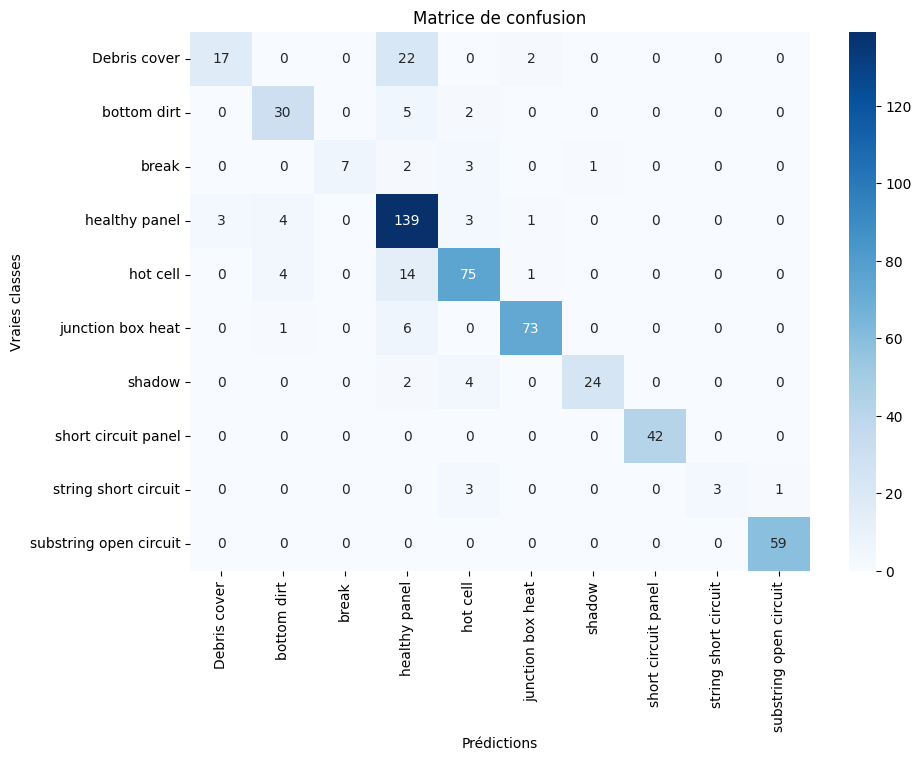

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.85      0.41      0.56        41
           bottom dirt       0.77      0.81      0.79        37
                 break       1.00      0.54      0.70        13
         healthy panel       0.73      0.93      0.82       150
              hot cell       0.83      0.80      0.82        94
     junction box heat       0.95      0.91      0.93        80
                shadow       0.96      0.80      0.87        30
   short circuit panel       1.00      1.00      1.00        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      1.00      0.99        59

              accuracy                           0.85       553
             macro avg       0.91      0.76      0.81       553
          weighted avg       0.86      0.85      0.84       553


Entraînement :  GLCM/Entropie + SVM


Pipeline(steps=[('Preprocessing',
                 FeatureUnion(transformer_list=[('Pipeline GLCM',
                                                 Pipeline(steps=[('Extraction '
                                                                  'GLCM',
                                                                  GLCMExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())])),
                                                ('Pipeline Entropie',
                                                 Pipeline(steps=[('Entropie',
                                                                  EntropyExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())]))])),
                ('Modeling', SVC(C=10))])

,Pipeline GLCM__contrast_d1_a0,Pipeline GLCM__contrast_d1_a45,Pipeline GLCM__contrast_d1_a90,Pipeline GLCM__contrast_d1_a135,Pipeline GLCM__dissimilarity_d1_a0,Pipeline GLCM__dissimilarity_d1_a45,Pipeline GLCM__dissimilarity_d1_a90,Pipeline GLCM__dissimilarity_d1_a135,Pipeline GLCM__homogeneity_d1_a0,Pipeline GLCM__homogeneity_d1_a45,...,Pipeline Entropie__entropy_hist_bin1,Pipeline Entropie__entropy_hist_bin2,Pipeline Entropie__entropy_hist_bin3,Pipeline Entropie__entropy_hist_bin4,Pipeline Entropie__entropy_hist_bin5,Pipeline Entropie__entropy_hist_bin6,Pipeline Entropie__entropy_hist_bin7,Pipeline Entropie__entropy_hist_bin8,Pipeline Entropie__entropy_hist_bin9,Pipeline Entropie__entropy_hist_bin10
553,-0.202637,-0.276631,-0.126860,-0.258727,0.011815,-0.194511,-0.070816,-0.181414,-0.555304,-0.415650,...,-0.183827,-0.512681,-0.868177,-1.259075,-0.628838,1.690952,1.916545,0.067706,-0.083276,-0.132783
554,-0.826254,-0.724360,-0.456227,-0.742628,-0.483174,-0.458639,-0.356662,-0.515905,-0.661548,-0.513246,...,-0.183827,-0.512681,-0.805495,-0.970846,-0.628580,0.906470,1.625881,0.598936,0.065848,-0.651549
555,-0.628240,-0.262360,0.154932,-0.245153,-0.657592,-0.305244,0.034106,-0.313091,0.317455,0.137411,...,-0.183827,-0.482659,-0.429826,-0.128892,0.649084,1.570608,0.701699,-1.302064,-1.070062,-0.002375
556,-0.873160,-0.683151,-0.260667,-0.632054,-0.673276,-0.511825,-0.130854,-0.430826,-0.122626,0.027070,...,-0.183827,-0.502524,-0.608436,-0.387017,0.546924,1.124659,0.798997,-0.224632,-0.724215,-0.821468
557,0.366109,0.259110,0.500173,0.320163,0.358067,0.137118,0.376751,0.166255,-0.192226,-0.100234,...,-0.183827,-0.482722,-0.566692,0.019788,0.875932,0.909684,-0.329658,-1.009195,-0.302188,0.027692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-0.908163,-0.850679,-0.549503,-0.857648,-1.410072,-1.157166,-0.844138,-1.179637,1.817506,1.860500,...,0.104159,0.118425,-0.011108,1.350189,2.209691,0.409856,0.514198,1.203900,-0.295145,-0.581662
5568,-0.740337,-0.707541,-0.483492,-0.705737,-1.070025,-0.791596,-0.452329,-0.791577,0.968614,0.484343,...,-0.183827,-0.512681,-0.755244,-0.439769,0.701163,0.141966,0.164365,1.225788,1.194742,0.494842
5569,-0.983681,-0.852220,-0.569450,-0.860764,-1.135001,-0.818047,-0.506352,-0.853930,0.696979,0.351312,...,-0.183827,-0.512681,-0.847730,-0.772325,0.553379,1.389111,0.726761,0.462384,0.889394,0.662994
5570,-0.971153,-0.920115,-0.683515,-0.928491,-1.365778,-1.164466,-0.916785,-1.183552,1.671042,1.808309,...,0.037168,0.684906,1.580292,1.493804,1.102614,0.054261,0.255414,0.407380,-0.452721,-0.476937


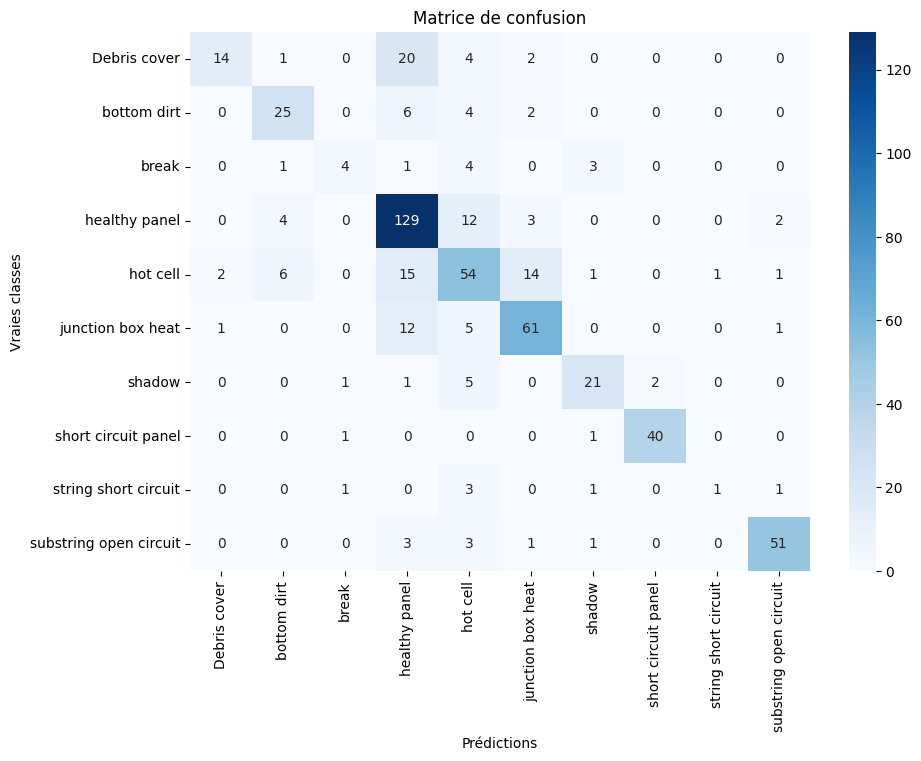

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.82      0.34      0.48        41
           bottom dirt       0.68      0.68      0.68        37
                 break       0.57      0.31      0.40        13
         healthy panel       0.69      0.86      0.77       150
              hot cell       0.57      0.57      0.57        94
     junction box heat       0.73      0.76      0.75        80
                shadow       0.75      0.70      0.72        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       0.50      0.14      0.22         7
substring open circuit       0.91      0.86      0.89        59

              accuracy                           0.72       553
             macro avg       0.72      0.62      0.64       553
          weighted avg       0.73      0.72      0.71       553


Entraînement :  HOG/GLCM/Entropie + SVM


Pipeline(steps=[('Preprocessing',
                 FeatureUnion(transformer_list=[('Pipeline HOG',
                                                 Pipeline(steps=[('Extraction '
                                                                  'HOG',
                                                                  HOGExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())])),
                                                ('Pipeline GLCM',
                                                 Pipeline(steps=[('Extraction '
                                                                  'GLCM',
                                                                  GLCMExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())])),
                                                ('Pipeline Entropie',
                                                 Pipeline(steps=[('Entropie',
                                                                  EntropyExtractor()),
                                                                 ('Standardisation',
                                                                  StandardScaler())]))])),
                ('Modeling', SVC(C=10))])

,Pipeline HOG__HOG_1,Pipeline HOG__HOG_2,Pipeline HOG__HOG_3,Pipeline HOG__HOG_4,Pipeline HOG__HOG_5,Pipeline HOG__HOG_6,Pipeline HOG__HOG_7,Pipeline HOG__HOG_8,Pipeline HOG__HOG_9,Pipeline HOG__HOG_10,...,Pipeline Entropie__entropy_hist_bin1,Pipeline Entropie__entropy_hist_bin2,Pipeline Entropie__entropy_hist_bin3,Pipeline Entropie__entropy_hist_bin4,Pipeline Entropie__entropy_hist_bin5,Pipeline Entropie__entropy_hist_bin6,Pipeline Entropie__entropy_hist_bin7,Pipeline Entropie__entropy_hist_bin8,Pipeline Entropie__entropy_hist_bin9,Pipeline Entropie__entropy_hist_bin10
553,0.086439,-1.040365,-0.091048,-1.072702,-0.020514,-0.170390,2.587848,1.772925,1.189901,0.876797,...,-0.183827,-0.512681,-0.868177,-1.259075,-0.628838,1.690952,1.916545,0.067706,-0.083276,-0.132783
554,0.108499,2.008504,0.562817,-1.585915,0.003353,-0.239505,2.766472,2.468437,1.205065,-0.707659,...,-0.183827,-0.512681,-0.805495,-0.970846,-0.628580,0.906470,1.625881,0.598936,0.065848,-0.651549
555,0.303547,-1.306800,0.666634,1.451114,0.214368,0.159273,1.714925,0.768587,-1.111446,1.064260,...,-0.183827,-0.482659,-0.429826,-0.128892,0.649084,1.570608,0.701699,-1.302064,-1.070062,-0.002375
556,-0.722137,-0.796724,-0.496764,1.508291,0.286981,2.112880,-0.933379,1.752289,-0.214083,-1.579702,...,-0.183827,-0.502524,-0.608436,-0.387017,0.546924,1.124659,0.798997,-0.224632,-0.724215,-0.821468
557,-0.138577,-1.306800,1.546047,1.074484,-0.263950,-0.462960,0.497094,2.451237,0.795502,0.682506,...,-0.183827,-0.482722,-0.566692,0.019788,0.875932,0.909684,-0.329658,-1.009195,-0.302188,0.027692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.739882,-0.589807,-1.009914,-0.076043,0.686424,-1.110611,-0.355057,-0.622813,1.180160,-0.646468,...,0.104159,0.118425,-0.011108,1.350189,2.209691,0.409856,0.514198,1.203900,-0.295145,-0.581662
5568,0.102156,-0.040069,-1.008694,0.145306,0.545428,0.237740,1.016495,0.327185,-0.685772,1.328485,...,-0.183827,-0.512681,-0.755244,-0.439769,0.701163,0.141966,0.164365,1.225788,1.194742,0.494842
5569,-0.229819,-0.059954,-0.065107,0.996758,-0.719961,0.944271,-0.279654,-0.867831,-1.111446,-0.055094,...,-0.183827,-0.512681,-0.847730,-0.772325,0.553379,1.389111,0.726761,0.462384,0.889394,0.662994
5570,1.163553,-1.122375,-0.908484,-1.266511,-0.649402,-0.689188,0.143030,-0.867831,1.079193,1.806835,...,0.037168,0.684906,1.580292,1.493804,1.102614,0.054261,0.255414,0.407380,-0.452721,-0.476937


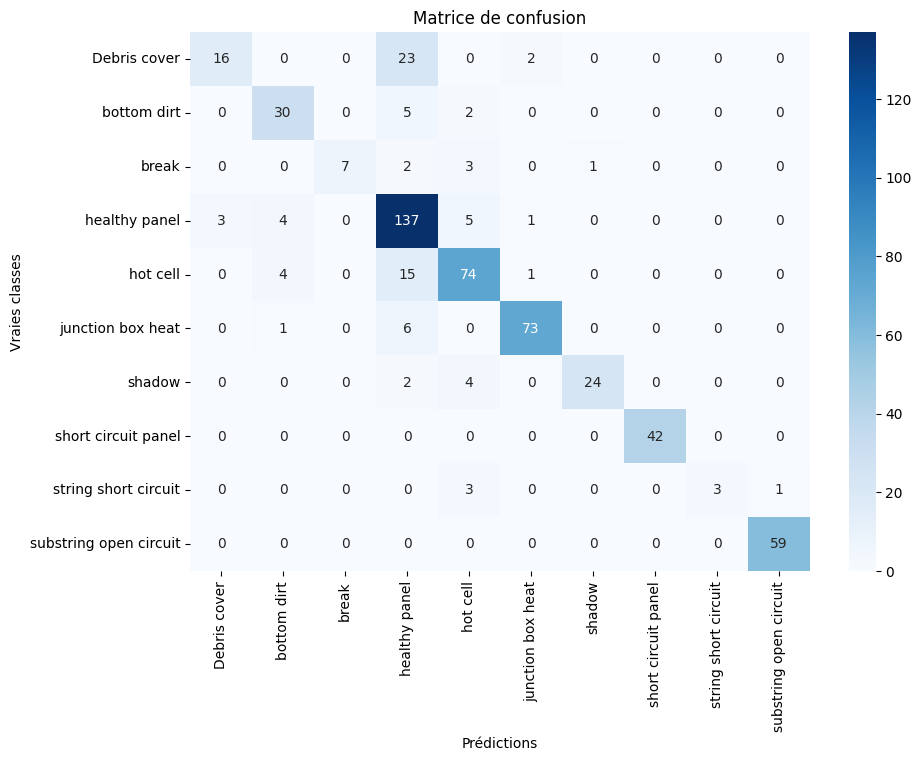

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.84      0.39      0.53        41
           bottom dirt       0.77      0.81      0.79        37
                 break       1.00      0.54      0.70        13
         healthy panel       0.72      0.91      0.81       150
              hot cell       0.81      0.79      0.80        94
     junction box heat       0.95      0.91      0.93        80
                shadow       0.96      0.80      0.87        30
   short circuit panel       1.00      1.00      1.00        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      1.00      0.99        59

              accuracy                           0.84       553
             macro avg       0.90      0.76      0.80       553
          weighted avg       0.85      0.84      0.83       553



In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pour chaque pipeline
for pipe_name,pipe in finalPipelines.items():
    print ("\nEntraînement : ",pipe_name)
    display(pipe)
    # Entraînement
    pipe.fit(X_train,y_train)
    # Afficher jeu d'entraînement transformé, juste avant l'étape de modélisation
    sub_pipe = pipe[:-1]
    X_train_transformed = sub_pipe.fit_transform(X_train,y_train)
    display (pd.DataFrame(X_train_transformed,index = X_train.index,columns=sub_pipe.get_feature_names_out()))
    # Prédiction
    y_pred = pipe.predict(X_test)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    # Rapport de classification
    class_report = classification_report(y_test, y_pred)
    print("Rapport de classification :\n", class_report)

### TODO

- Preprocessing : faire varier les paramètres des transformeurs (extracteurs + standardisation)
- Preprocessing : intégrer rééchantillonnage (ou 'balanced'), intégrer réduction de dimension
- Comparer l'importance des features (permutation_importance...)
- Comparer les résultats si on retire en entrée les images 'Doute_Carre'
- Essayer d'autres modèles : KNN, RandomForest, MLPClassifier, modèles d'ensemble
- Question : part-on dès maintenant sur un ensemble train / val / test commun à tout le monde ?
    - Pour chaque modèle, ajuster ses hyperparamètres sur l'ensemble train par validation croisée (GridSearch,...)
    - Entraîner tous les modèles optimisés sur l'ensemble train et comparer leur résultat sur l'ensemble val
    - Entraîner le meilleur modèle sur train + val, et vérifier sa bonne généralisation sur test.